In [1]:
import sys, os
sys.path.append(os.path.abspath(
    os.getcwd()+"/core")
)

In [2]:
from core.quantum_error_correction_code import SurfaceCode, deformation_cmap
from core.neural_network import CNNDual, CNN, load_params, save_params

from core.replay_buffer import UniformReplayBuffer
from core.agent import DQN

from core.environment import *

import jax.numpy as jnp
from jax import random, lax
from jax.tree_util import tree_map
import optax

import matplotlib.pyplot as plt
from time import time

# Hyper parameters

In [3]:
TRAINING_BATCHES = 500

CODE_DISTANCE = 3

INIT_LEARNING_RATE = 0
LEARNING_RATE = 1E-3
WARMUP_STEPS = 0
TRANSITION_STEP = 100
DECAY_RATE = 0.95

SEED = 362

ENVIRONMENT_TYPE = "PML" # PML, Lookup, CNN-noiseless or CNN
AGENT_CONV_LAYERS = [(4,3,1,1), (3,3,1,1), (4,3,1,1), (6,3,1,1)]

# Training baches are low enough to all be stored in the buffer
BUFFER_SIZE = TRAINING_BATCHES
BATCH_SIZE = 32

DISCOUNT_FACTOR = .8

ESTIMATION_SHOTS = 500_000

In [4]:
save_data = True

NAME = f"RL-{ENVIRONMENT_TYPE}-{CODE_DISTANCE}"

print(NAME)

RL-PML-3


# Initialize the code

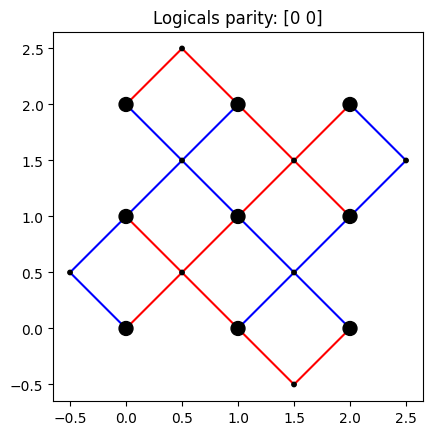

In [5]:
code = SurfaceCode(CODE_DISTANCE)
parity_info = code.deformation_parity_info(jnp.zeros(code.num_data_qubits, dtype=jnp.int32))
code.show(parity_info)

# Optimizer

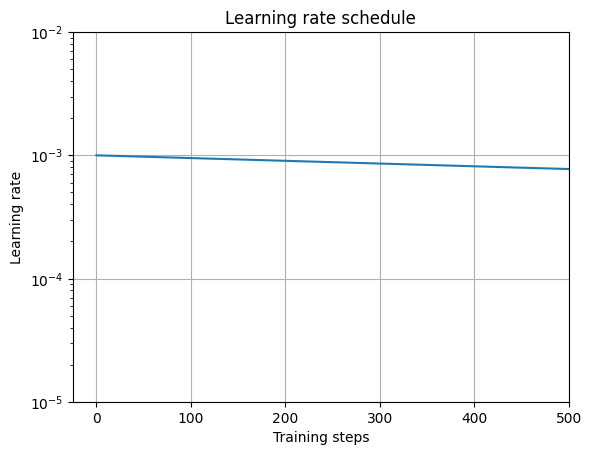

In [6]:
learning_rate = optax.warmup_exponential_decay_schedule(
    init_value=INIT_LEARNING_RATE,
    peak_value=LEARNING_RATE,
    warmup_steps=WARMUP_STEPS,
    transition_steps=TRANSITION_STEP,
    decay_rate=DECAY_RATE
)

step = jnp.linspace(0, TRAINING_BATCHES, 1000)

plt.figure()
plt.plot(step, learning_rate(step))
plt.yscale('log')
plt.title("Learning rate schedule")
plt.xlabel("Training steps")
plt.ylabel("Learning rate")
plt.grid()
plt.xlim(xmax=TRAINING_BATCHES)
plt.ylim(1E-5, 1E-2)
plt.show()

optimizer = optax.adam(learning_rate)

# Load a decoder

In [7]:
settings, decoder_params = load_params(f"data/CNN-G-{CODE_DISTANCE}.json")

# Replay buffer

In [8]:
replay_buffer = UniformReplayBuffer(
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    num_qubits=CODE_DISTANCE**2
)
buffer_state = replay_buffer.empty_buffer()

# Agent

In [9]:
class AgentModel(CNN):

    def __init__(self, input_shape, conv_layers):
        super().__init__(input_shape, conv_layers)

    def apply_single(
        self,
        params: list[dict[str, jnp.ndarray]],
        x: jnp.ndarray,
    ) -> jnp.ndarray:
        """Applies the CNN to a batch of input x."""
        return super().apply_single(
            params,
            code.deformation_image(x)
        )

agent_model = AgentModel(
    input_shape=(6, CODE_DISTANCE, CODE_DISTANCE),
    conv_layers=AGENT_CONV_LAYERS
)
display(agent_model.layer_sizes)

agent = DQN(
    model=agent_model,
    discount=DISCOUNT_FACTOR,
    num_data_qubits=CODE_DISTANCE*CODE_DISTANCE
)

# Epsilon scaling
def inverse_scaling_decay(epsilon_start, epsilon_end, current_step, decay_rate):
    return epsilon_end + (epsilon_start - epsilon_end) / (1 + decay_rate * current_step)

[(6, 3, 3), (4, 3, 3), (3, 3, 3), (4, 3, 3), (6, 3, 3)]

# Environment

In [10]:
if ENVIRONMENT_TYPE == "CNN":
    decoder_model = CNNDual(
        input_shape_1 = (1, CODE_DISTANCE+1, CODE_DISTANCE+1),
        input_shape_2 = (6, CODE_DISTANCE, CODE_DISTANCE),
        conv_layers_input_1 = jnp.array(settings["CONV_LAYERS_INPUT_1"]),
        conv_layers_input_2 = jnp.array(settings["CONV_LAYERS_INPUT_2"]),
        conv_layers_stage_2 = jnp.array(settings["CONV_LAYERS_STAGE_2"]),
        fc_layers = jnp.array(settings["FC_LAYERS"])
    )
    display(decoder_model.layer_sizes)

    env = EnvironmentCNN(
        model=decoder_model,
        model_params=decoder_params,
        noise_model=settings["ERROR_PROBS"],
        code=code,
        shots=ESTIMATION_SHOTS
    )
elif ENVIRONMENT_TYPE == "CNN-noiseless":
    # Impractival beyond distance 3 surface codes ?
    decoder_model = CNNDual(
        input_shape_1 = (1, CODE_DISTANCE+1, CODE_DISTANCE+1),
        input_shape_2 = (6, CODE_DISTANCE, CODE_DISTANCE),
        conv_layers_input_1 = jnp.array(settings["CONV_LAYERS_INPUT_1"]),
        conv_layers_input_2 = jnp.array(settings["CONV_LAYERS_INPUT_2"]),
        conv_layers_stage_2 = jnp.array(settings["CONV_LAYERS_STAGE_2"]),
        fc_layers = jnp.array(settings["FC_LAYERS"])
    )
    display(decoder_model.layer_sizes)

    env = EnvironmentNoiselessCNN(
        model=decoder_model,
        model_params=decoder_params,
        noise_model=settings["ERROR_PROBS"],
        code=code,
    )
elif ENVIRONMENT_TYPE == "Lookup":
    # Mainly intended for testing purposes on distance 3 surface codes (Impractical for larger distances)
    all_logical_error_rates = jnp.load("data/environmentNoiselessCNN_error_rates_p01_nu500_halve.npy")
    equivalence_mapper = lambda d: jnp.array([0,0,2,3,3,2])[d]
    env = EnvironmentLookup(
        lookup_table=all_logical_error_rates,
        num_of_deformations=3,
        code=code,
        equivalence_mapper=equivalence_mapper
    )
elif ENVIRONMENT_TYPE == "PML":
    # Impractival beyond distance 3 surface codes
    env = EnvironmentPML(
        noise_model=settings["ERROR_PROBS"],
        code=code,
    )
else:
    raise ValueError(f"No environment of type \"{ENVIRONMENT_TYPE}\" found")

if CODE_DISTANCE == 3:
    all_logical_error_rates_truth = jnp.load("data/environmentPML_error_rates_p01_nu500_halve.npy")
    equivalence_mapper = lambda d: jnp.array([0,0,2,3,3,2])[d]
    env_truth = EnvironmentLookup(
        lookup_table=all_logical_error_rates_truth,
        num_of_deformations=3,
        code=code,
        equivalence_mapper=equivalence_mapper
    )
else:
    all_logical_error_rates_truth = jnp.array(jnp.nan)

print(ENVIRONMENT_TYPE)

PML


# Train the RL-agent

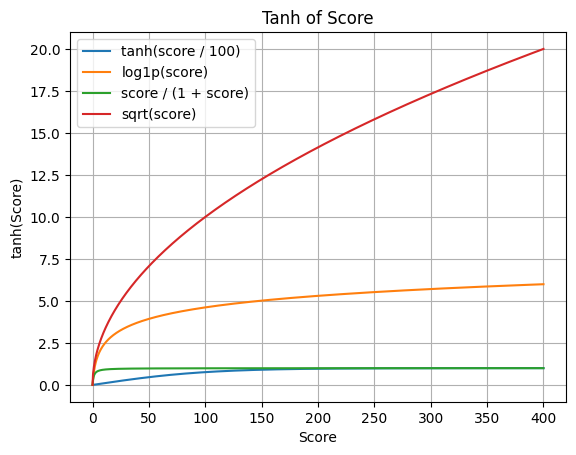

In [11]:
score = jnp.linspace(0, 400, 1000)

plt.plot(score, jnp.tanh(score / 100), label="tanh(score / 100)")
plt.plot(score, jnp.log1p(score), label="log1p(score)")
plt.plot(score, score / (1 + score), label="score / (1 + score)")
plt.plot(score, jnp.sqrt(score), label="sqrt(score)")
plt.legend()
plt.title("Tanh of Score")
plt.xlabel("Score")
plt.ylabel("tanh(Score)")
plt.grid()
plt.show()

In [12]:
def train(
    timesteps: int,
    random_seed: int,
    tau: float,
    model: CNN,
    optimizer: optax.GradientTransformation,
    buffer_state: dict,
    buffer_size: int,
    agent: DQN,
    env: EnvironmentBase,
    replay_buffer: UniformReplayBuffer,
    epsilon_decay_fn,
    epsilon_start: float,
    epsilon_end: float,
    decay_rate: float,
):
    """
    Train the RL-agent to find the best deformation of the given size surface code
    """

    def _fori_body(
        i: int,
        val: tuple
    ):
        """
        Performs a single step of training
        """
        (
            online_net_params,
            target_net_params,
            deformation,
            deformations,
            score,
            scores,
            rewards,
            dones,
            disallowed_actions,
            opt_state,
            buffer_state,
            act_key,
            env_key,
            sample_key,
            losses,
        ) = val
        
        # Let agent pick a deformation action
        action, done, act_key = agent.act(
            act_key,
            online_net_params,
            deformation,
            disallowed_actions,
            epsilon = epsilon_decay_fn(epsilon_start, epsilon_end, i, decay_rate),
        )
        deformation_action_idx, data_qubit_action_idx = agent.split_action(action)


        # Update the deformation
        new_deformation = deformation.at[data_qubit_action_idx].set(deformation_action_idx)

        # Calculate the agents reward
        reward, new_score, env_key = env.reward(
            env_key,
            new_deformation,
        )

        # Add the current experience to the buffer
        experience = (deformation, score, action, reward, new_deformation, done)
        buffer_state = replay_buffer.add(
            buffer_state,
            experience,
            idx=i
        )

        # Add the reverse experience to the buffer
        inv_action = agent.merge_action(
            deformation[data_qubit_action_idx],
            data_qubit_action_idx
        )
        experience_inv = (new_deformation, new_score, inv_action, -reward, deformation, False)
        buffer_state = replay_buffer.add(
            buffer_state,
            experience_inv,
            idx=i
        )

        # Update the agent
        experiences, sample_key = replay_buffer.sample(
            sample_key,
            buffer_state,
            jnp.min(jnp.array([i, buffer_size]))
        )
        online_net_params, opt_state, loss = agent.update(
            online_net_params,
            target_net_params,
            optimizer,
            opt_state,
            experiences,
        )

        # update the target parameters to be tau closer to the online parameters
        target_net_params = tree_map(
            lambda target, online: (1 - tau) * target + tau * online, 
            target_net_params, 
            online_net_params
        )

        (
            disallowed_actions,
            final_deformation,
            final_score,
        ) = lax.cond(
            new_score > score,
            lambda: (
                    jnp.zeros_like(disallowed_actions)
                        # Do not allow actions that will leave the deformation unchanged
                        .at[env.num_qubits*new_deformation + jnp.arange(env.num_qubits)].set(True)
                        # Do not allow the action that will go back to the just seen state
                        .at[agent.merge_action(
                            deformation_action_idx=deformation[data_qubit_action_idx],
                            data_qubit_action_idx=data_qubit_action_idx
                        )].set(True),
                    new_deformation,
                    new_score,
                ),
            lambda: (
                    # Do not allow the action that was just taken as that did not yield a better deformation
                    disallowed_actions.at[action].set(True),
                    deformation,
                    score,
                ),
        )

        # Update tracked information
        rewards = rewards.at[i].set(reward)
        losses = losses.at[i].set(loss)
        deformations = deformations.at[i].set(final_deformation)
        scores = scores.at[i].set(final_score)
        dones = dones.at[i].set(done)

        return (
            online_net_params,
            target_net_params,
            final_deformation,
            deformations,
            final_score,
            scores,
            rewards,
            dones,
            disallowed_actions,
            opt_state,
            buffer_state,
            act_key,
            env_key,
            sample_key,
            losses,
        )
    
    act_key, sample_key, env_key, init_online_key, init_target_key = random.split(
        random.key(random_seed), num=5
    )

    target_net_params = model.init(init_target_key)
    online_net_params = model.init(init_online_key)

    deformation, score, env_key = env.reset(env_key)

    opt_state = optimizer.init(online_net_params)

    losses = jnp.empty(timesteps, dtype=jnp.float32)
    rewards = jnp.empty(timesteps, dtype=jnp.float32)
    scores = jnp.empty(timesteps, dtype=jnp.float32)
    dones = jnp.zeros(timesteps, dtype=jnp.bool)
    deformations = jnp.empty((timesteps, agent.num_data_qubits), dtype=jnp.int32)
    disallowed_actions = jnp.zeros(
        agent.num_data_qubits*agent.num_deformations, 
        dtype=jnp.bool
    ).at[
        agent.merge_action(deformation, jnp.arange(agent.num_data_qubits))
    ].set(True)

    val_init = (
        online_net_params,
        target_net_params,
        deformation,
        deformations,
        score,
        scores,
        rewards,
        dones,
        disallowed_actions,
        opt_state,
        buffer_state,
        act_key,
        env_key,
        sample_key,
        losses,
    )

    # vals = _fori_body(0, val_init)
    vals = lax.fori_loop(0, TRAINING_BATCHES, _fori_body, val_init)

    return vals

In [13]:
t0 = time()
(
    online_net_params,
    target_net_params,
    deformation,
    deformations,
    score,
    scores,
    rewards,
    dones,
    disallowed_actions,
    opt_state,
    buffer_state,
    act_key,
    env_key,
    sample_key,
    losses,
) = train(
    timesteps = TRAINING_BATCHES,
    random_seed = SEED,
    tau = 0.1,
    model = agent_model,
    optimizer = optimizer,
    buffer_state = buffer_state,
    buffer_size = BUFFER_SIZE,
    agent = agent,
    env = env,
    replay_buffer = replay_buffer,
    epsilon_decay_fn = inverse_scaling_decay,
    epsilon_start = 0.5,
    epsilon_end = 0.0,
    decay_rate = 1E-3,
)

print(deformation)

if save_data:
    save_params(
        online_net_params,
        {
            "deformations": deformations,
            "scores": scores,
            "rewards": rewards,
            "dones": dones,
            "losses": losses
        },
        f"data/{NAME}.json"
    )
    jnp.save(
        f"data/loss_{NAME}.npy",
        losses,
    )

training_time = time() - t0
print(f"{int(training_time/60/60):5d}h {int(training_time/60%60):02d}m {int(training_time%60):02d}s", end='\r')

[5 5 0 4 2 2 0 2 4]


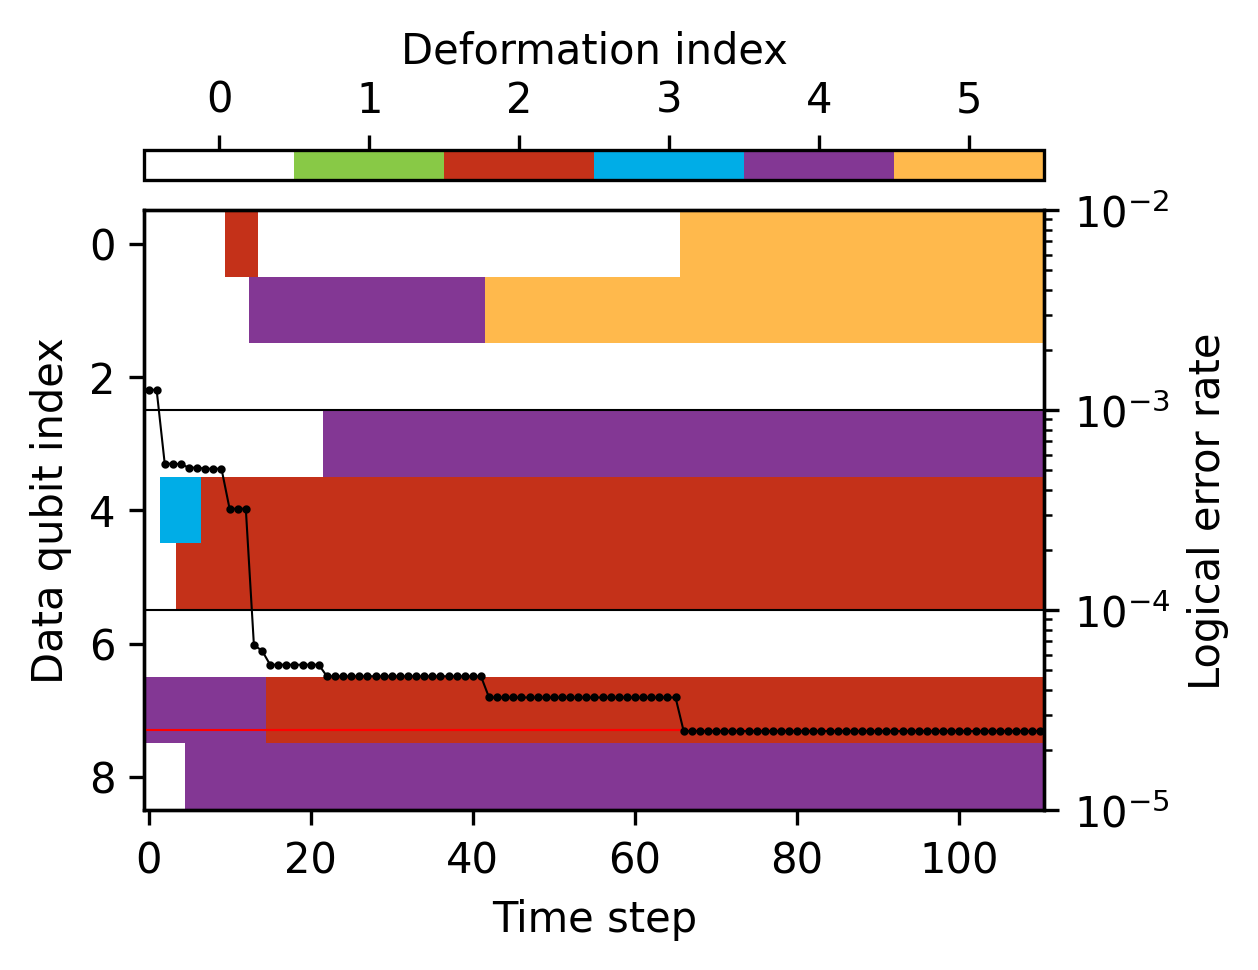

In [14]:
error_rates = -jnp.log(.99) / scores[~dones]

fig = plt.figure(dpi=300, figsize=(3,2))

im_aspect = (~dones).sum() / deformations.shape[1]
fig_aspect = fig.get_figheight() / fig.get_figwidth()

ax = fig.add_axes((0,0,1,1))
im = ax.imshow(deformations[~dones].T, aspect=im_aspect*fig_aspect, interpolation="nearest", cmap=deformation_cmap, vmin=-.5, vmax=5.5)
ax.set_xlabel("Time step")
ax.set_ylabel("Data qubit index")
ax.set_xlim(-.5, (~dones).sum()-.5)
ax.hlines(CODE_DISTANCE*jnp.arange(CODE_DISTANCE)[1:]-.5, [-1]*(CODE_DISTANCE-1), [error_rates.shape[0]]*(CODE_DISTANCE-1), color='k', lw=.5)
tax = ax.twinx()
if CODE_DISTANCE == 3:
    if ENVIRONMENT_TYPE != "PML":
        true_logical_error_rate = vmap(
            lambda state: env_truth._get_state_error_rate(None, state)[0]
        )(deformations[~dones])
        lns2 = tax.plot(range(error_rates.shape[0]), true_logical_error_rate, '.-r', lw=.5, ms=2)
    tax.hlines([all_logical_error_rates_truth.min()], [-.5], [(~dones).sum()-.5], color='r', lw=.5)
lns2 = tax.plot(range(error_rates.shape[0]), error_rates, '.-k', lw=.5, ms=2)
tax.set_yscale('log')
tax.set_ylim(1E-5, 1E-2)
tax.set_ylabel("Logical error rate")
cax = fig.add_axes((0,1.05,1,.05))
cbar = plt.colorbar(im, cax, orientation='horizontal')
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
cbar.set_label("Deformation index")

if save_data:
    plt.savefig(f"figs/evolution_{NAME}.eps", bbox_inches='tight')
    plt.savefig(f"figs/evolution_{NAME}.png", bbox_inches='tight')

plt.show()

[2 2 0 3 2 2 0 2 3]


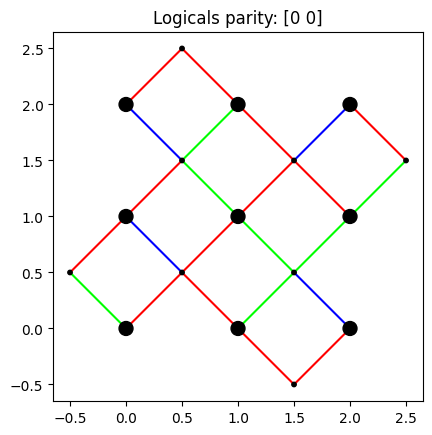

% Draw the plaquettes
\filldraw[fill=black!10, draw=none] (0,0) -- (2,0) -- (2,2) -- (0,2) -- cycle;
\filldraw[fill=black!5, draw=none] (0,2) -- (2,2) -- (2,4) -- (0,4) -- cycle;
\filldraw[fill=black!5, draw=none] (2,0) -- (4,0) -- (4,2) -- (2,2) -- cycle;
\filldraw[fill=black!10, draw=none] (2,2) -- (4,2) -- (4,4) -- (2,4) -- cycle;
\filldraw[fill=black!5, draw=none] (0,0) -- (0,2) -- (-1,1) -- cycle;
\filldraw[fill=black!5, draw=none] (4,2) -- (4,4) -- (5,3) -- cycle;
\filldraw[fill=black!10, draw=none] (2,0) -- (4,0) -- (3,-1) -- cycle;
\filldraw[fill=black!10, draw=none] (0,4) -- (2,4) -- (1,5) -- cycle;

% Draw the data qubits
\node[draw, circle, fill=BrickRed, line width=.5mm, minimum size=5mm] (D0) at (0.0,0.0) {};
\node[draw, circle, fill=BrickRed, line width=.5mm, minimum size=5mm] (D1) at (2.0,0.0) {};
\node[draw, circle, fill=White, line width=.5mm, minimum size=5mm] (D2) at (4.0,0.0) {};
\node[draw, circle, fill=Cerulean, line width=.5mm, minimum size=5mm] (D3) at (0.0,2.0)

In [15]:
deformation_ = jnp.array([0,0,2,3,3,2])[deformation]
print(deformation_)
parity_info = code.deformation_parity_info(deformation_)
code.show(parity_info)
print(code.show_latex_code(parity_info, deformation_))

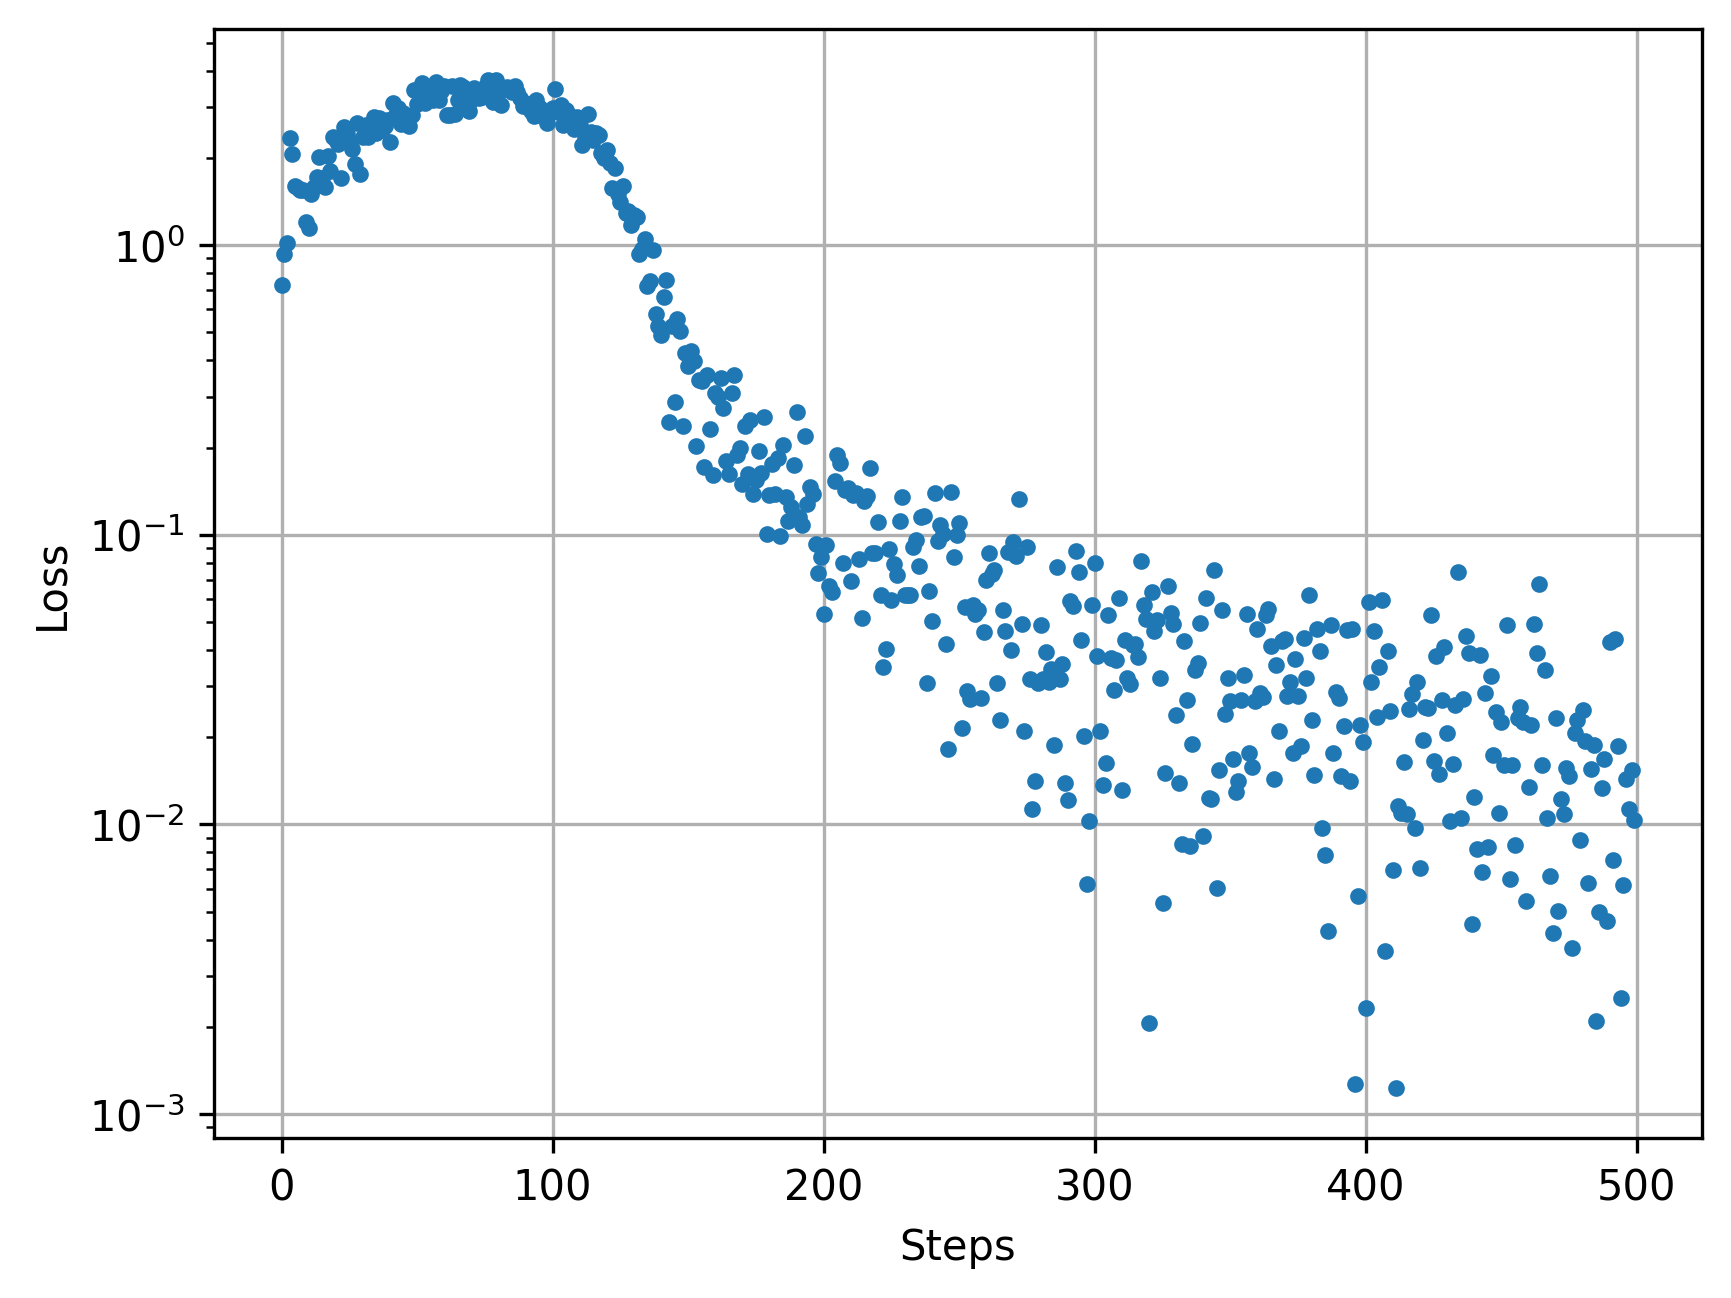

In [16]:
end = losses.shape[0]
plt.figure(dpi=300)
plt.plot(jnp.arange(end), losses, '.', lw=.5)
plt.grid()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yscale('log')
# plt.xlim(50000, 51000)
plt.show()